In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import librosa
import librosa.display
from scipy import signal
import soundfile as sf

### Parameters

In [3]:
melspec_parameters = {
    "n_mels": 256,
    "fmin": 20,
    "fmax": 16000
}

pcen_parameters = {
    "gain": 0.98,
    "bias": 2,
    "power": 0.5,
    "time_constant": 0.4,
    "eps": 0.000001
}

In [4]:
def BandRejectFilter(y, sr, lowcut, highcut, order):
    nyq = 0.5 * sr
    low = lowcut/nyq
    high = highcut/nyq
    b, a = signal.butter(order, [low, high], btype='bandstop')
    
    filt_signal = signal.filtfilt(b, a, y)
    return filt_signal

### Data loading

In [5]:
FRAME_SIZE = 2048
HOP_SIZE = 512
filename = 'PER49_20190131.wav'
# loading data
waveform, sr = librosa.load(filename, sr=None)
freq_spec = librosa.power_to_db(np.abs((librosa.stft(waveform)))**2, ref=np.max)
# print info
print('Sampling at ' + str(sr) +' hz')
print(waveform)
print('This is a ' + str(type(waveform)) + ' with ' + str(waveform.shape[0]) + ' samples of type ' + str(waveform.dtype))

Sampling at 32000 hz
[-0.00344835 -0.00120202 -0.00127646 ... -0.00243039  0.00357763
  0.00035556]
This is a <class 'numpy.ndarray'> with 19200000 samples of type float32


In [6]:
freq_spec.shape

(1025, 37501)

### Data Visualization

Text(0.5, 1.0, 'Waveform')

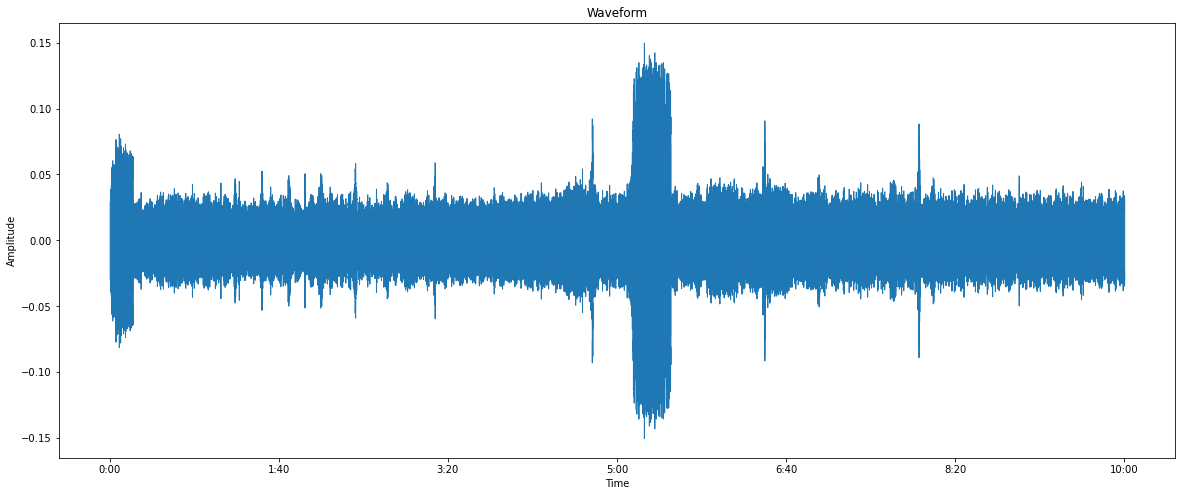

In [7]:
plt.figure(figsize=(20,8))
wave_img = librosa.display.waveshow(waveform,
                                    sr=sr)
plt.ylabel('Amplitude')
plt.title('Waveform')

### Frequency Spectrogram

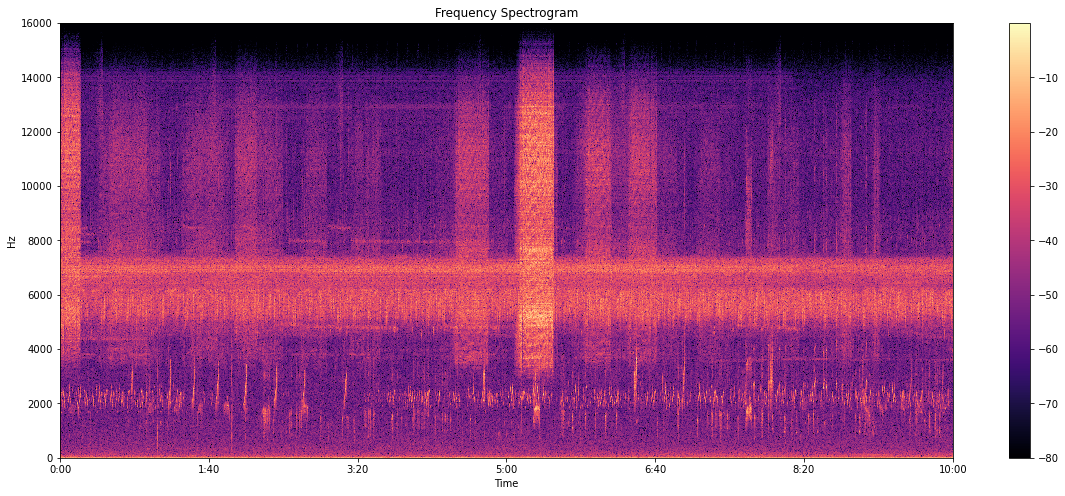

In [8]:
plt.figure(figsize=(20,8))
lin_img = librosa.display.specshow(freq_spec, 
                                   y_axis='linear',
                                   x_axis='time',
                                   sr=sr)
plt.title('Frequency Spectrogram')
plt.colorbar(lin_img)

### Log-Mel Spectrogram

Text(0.5, 1.0, 'Log-Mel Spectrogram')

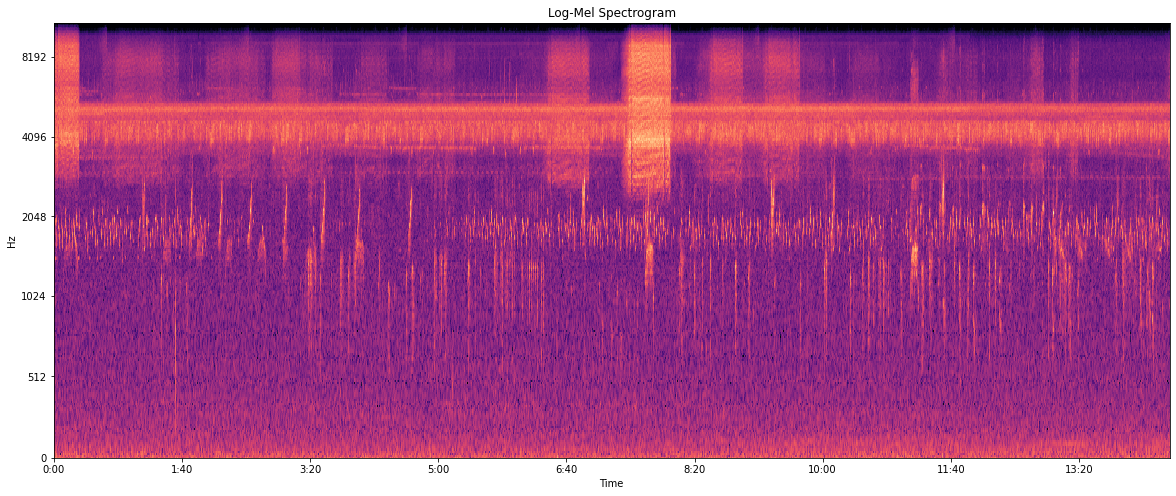

In [9]:
mel_spec = librosa.feature.melspectrogram(waveform,
                                          sr=sr,
                                          **melspec_parameters)
logmel_spec = librosa.power_to_db(mel_spec, ref=np.max)

plt.figure(figsize=(20,8))
logmel_img = librosa.display.specshow(logmel_spec,
                                      y_axis='mel',
                                      x_axis='time')
plt.title('Log-Mel Spectrogram')

In [10]:
mel_spec.shape

(256, 37501)

### Band Reject Filter

C:\Users\Mushfique Hasan Khan\.conda\envs\chckn\lib\site-packages\librosa\util\utils.py:198: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  warnings.warn(


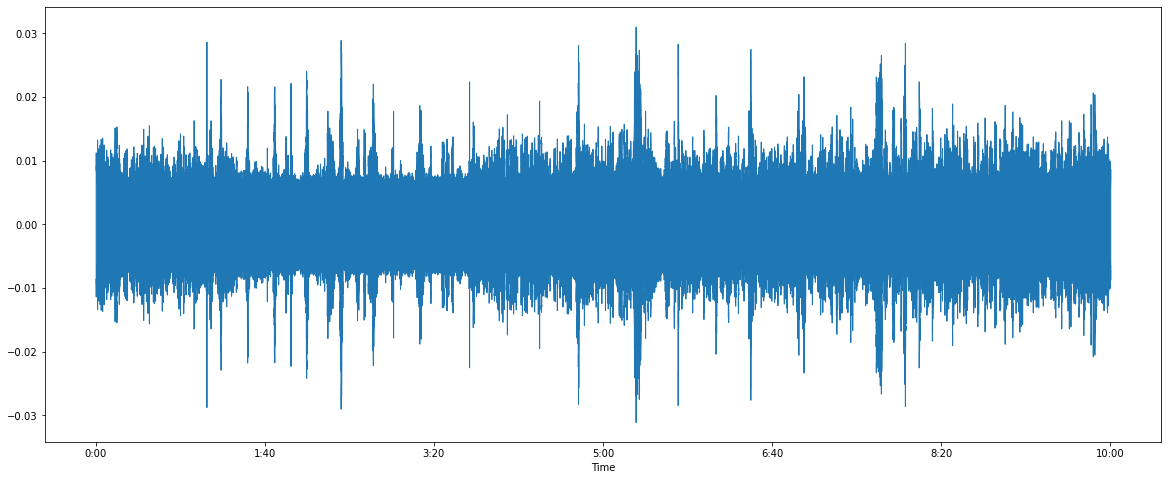

In [11]:
# Band Reject Filter Parameters
lowcut = 2500
highcut = 15000
order = 2
filt_wave = BandRejectFilter(waveform , sr, lowcut, highcut, order)

plt.figure(figsize=(20,8))
filt_img = librosa.display.waveshow(filt_wave,
                                    sr=sr)

In [12]:
# sf.write('filtered.wav', filt_wave, 32000, 'PCM_24')

### Filtered Log-Mel Spectrogram

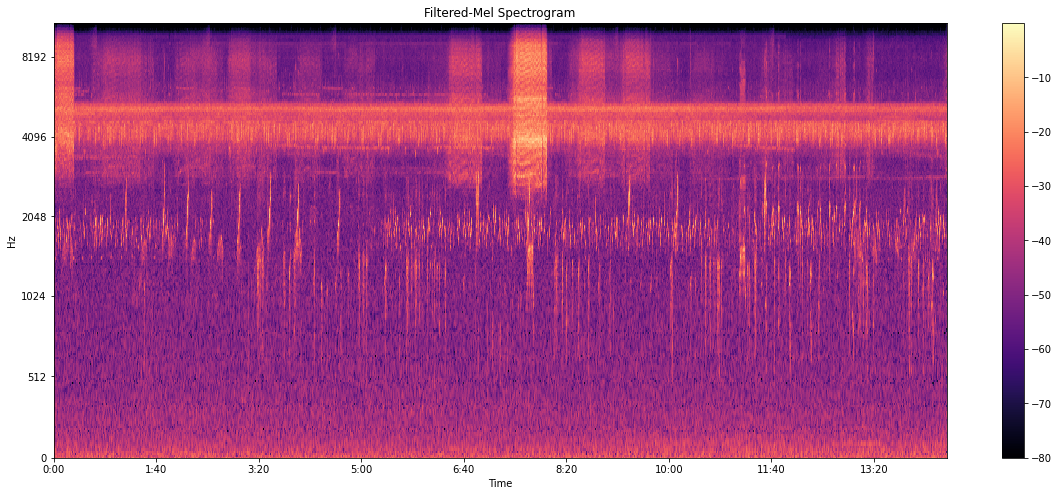

In [13]:
filt_spec = librosa.feature.melspectrogram(waveform,
                                           sr=sr, 
                                           **melspec_parameters)
logfilt_spec = librosa.power_to_db(filt_spec, ref=np.max)

plt.figure(figsize=(20,8))
melfilt_img = librosa.display.specshow(logfilt_spec, 
                                       y_axis='mel',
                                       x_axis='time')
plt.title('Filtered-Mel Spectrogram')
plt.colorbar(melfilt_img)

### PCEN

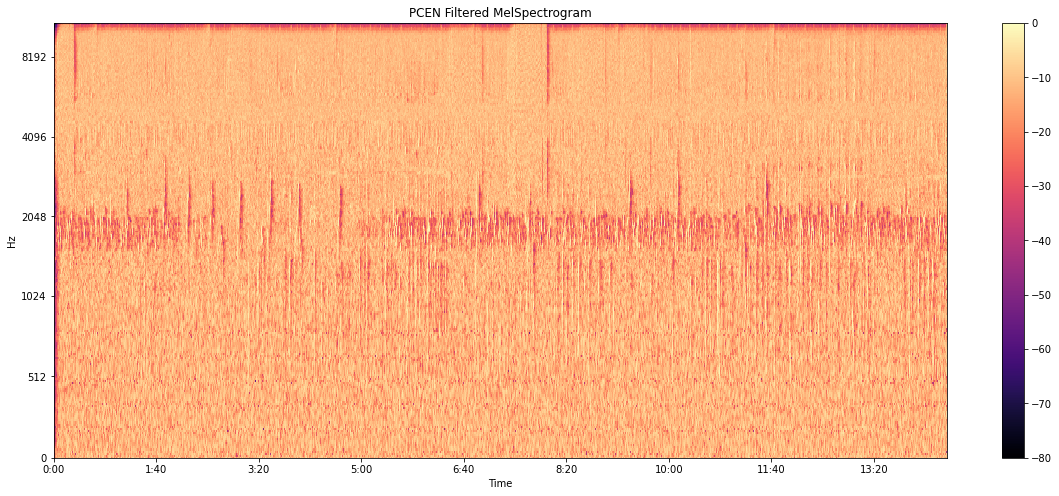

In [14]:
pcen = librosa.pcen(mel_spec,
                    sr=sr,
                    **pcen_parameters)
logpcen = librosa.power_to_db(pcen, ref=np.max)

plt.figure(figsize=(20,8))
logpcen_img = librosa.display.specshow(logpcen,
                                       y_axis='mel',
                                       x_axis='time')
plt.title('PCEN Filtered MelSpectrogram')
plt.colorbar(logpcen_img)

In [15]:
type(pcen)

numpy.ndarray

In [16]:
type(logfilt_spec)

numpy.ndarray

In [17]:
logpcen.shape

(256, 37501)

In [18]:
time_shape = logfilt_spec.shape[1]

In [19]:
time_label = np.linspace(0,60,time_shape)
features_img = np.stack([pcen, filt_spec], axis=-1)
time_label.shape
features_img.shape

(256, 37501, 2)

## Creating Models

In [20]:
import torch
import torchvision
from torchvision.transforms import transforms

In [21]:
batch_size = 4

train_data = torchvision.datasets.MNIST(root='data',
                                        train=True,
                                        transform=transforms.ToTensor(),
                                        download=True
                                        )
test_data = torchvision.datasets.MNIST(root='data',
                                       train=False,
                                       transform=transforms.ToTensor()
                                       )

In [22]:
# print(train_data)

In [23]:
# print(test_data)

In [24]:
# plt.imshow(train_data.data[0], cmap='gray')
# plt.title('%i' % train_data.targets[0])
# plt.show()

## DataLoader

In [25]:
from torch.utils.data import DataLoader

In [26]:
loaders = {
    'train':DataLoader(train_data,
                       batch_size=100,
                       shuffle=True,
                       num_workers=1),
    'test':DataLoader(test_data,
                      batch_size=100,
                     shuffle=True,
                     num_workers=1),
}
# loaders

## Defining the model

In [27]:
import torch.nn as nn

In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Sequential(
                                   nn.Conv2d(
                                             in_channels=1,
                                             out_channels=16,
                                             kernel_size=5,
                                             stride=1,
                                             padding=2,
                                            ),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),
                                  )
        self.conv2 = nn.Sequential(
                                   nn.Conv2d(
                                             in_channels=16,
                                             out_channels=32,
                                             kernel_size=5,
                                             stride=1,
                                             padding=2,
                                            ), 
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),
                                  )
        
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x

In [29]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


### Define Loss Function

In [30]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

### Optimization function

In [31]:
from torch import optim

In [32]:
optimizer = optim.Adam(cnn.parameters(), lr=0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

## TRAINING

In [33]:
from torch.autograd import Variable

num_epochs = 10

def train(num_epochs, cnn, loaders):
    cnn.train()
    
    #Train the model
    total_step = len(loaders['train'])
    
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            b_x = Variable(images)
            b_y = Variable(labels)
            
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)
            # clear gradients 
            optimizer.zero_grad()
            
            # backpropagation, conmpute gradients
            loss.backward()
            
            # apply gradients
            optimizer.step()
            
            if (i+1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
                pass
            pass
        pass
    
train(num_epochs, cnn, loaders)            

Epoch [1/10], Step [100/600], Loss: 0.1459
Epoch [1/10], Step [200/600], Loss: 0.0511
Epoch [1/10], Step [300/600], Loss: 0.1648
Epoch [1/10], Step [400/600], Loss: 0.0840
Epoch [1/10], Step [500/600], Loss: 0.0918
Epoch [1/10], Step [600/600], Loss: 0.0904
Epoch [2/10], Step [100/600], Loss: 0.0264
Epoch [2/10], Step [200/600], Loss: 0.0449
Epoch [2/10], Step [300/600], Loss: 0.0590
Epoch [2/10], Step [400/600], Loss: 0.1469
Epoch [2/10], Step [500/600], Loss: 0.1136
Epoch [2/10], Step [600/600], Loss: 0.1304
Epoch [3/10], Step [100/600], Loss: 0.0338
Epoch [3/10], Step [200/600], Loss: 0.0539
Epoch [3/10], Step [300/600], Loss: 0.0071
Epoch [3/10], Step [400/600], Loss: 0.0211
Epoch [3/10], Step [500/600], Loss: 0.0873
Epoch [3/10], Step [600/600], Loss: 0.0610
Epoch [4/10], Step [100/600], Loss: 0.1883
Epoch [4/10], Step [200/600], Loss: 0.0940
Epoch [4/10], Step [300/600], Loss: 0.0555
Epoch [4/10], Step [400/600], Loss: 0.0805
Epoch [4/10], Step [500/600], Loss: 0.0119
Epoch [4/10

In [34]:
def test():
    # Test the model
    cnn.eval()
    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item()/ float(labels.size(0))
            pass
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    pass
test()

Test Accuracy of the model on the 10000 test images: 0.98


In [35]:
sample = next(iter(loaders['test']))
imgs, lbls = sample
actual_number = lbls[:10].numpy()
actual_number

array([2, 2, 8, 2, 0, 9, 9, 7, 1, 8], dtype=int64)

In [36]:
test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [2 2 8 2 0 9 9 7 1 8]
Actual number: [2 2 8 2 0 9 9 7 1 8]
